# Map human scRNA-seq kidney on mouse Visium kidney

### 0929 - Mapping that shows patterns
- Parameter settings
```
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
    'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
    'lambda_f_reg' : 0,  # regularizer: filter values are Boolean
}
```
- It filters all cell but a single one with high probability.
- What happens if I removed the cell?
- The filters values are around 0 but are "different": maybe it is filtering?

In [1]:
# basic imports
import pandas as pd
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import scanpy as sc
import torch
import scipy
import matplotlib.patches as mpatches
import seaborn as sns
from IPython.display import display

# torch imports
from torch.nn.functional import softmax, cosine_similarity, sigmoid

# add `Tangram` to path
import sys
sys.path.append("../../") 

# Tangram imports
import mapping.utils
import mapping.mapping_optimizer
import mapping.plot_utils

In [2]:
'Folder where data are stored'
fld = '.'
fld = os.path.join(home, 'kidney_dataset')
assert os.path.isdir(fld)

In [3]:
'Load snRNA-seq data (AnnData format)'
path = os.path.join(fld, 'human_kidney_map.h5ad')
ad_sc = sc.read_h5ad(path)
# Convert mouse genes to human convention
ad_sc.var.index = ad_sc.var.index.str.upper()
ad_sc.var_names_make_unique()

In [4]:
'Load spatial Visium data (AnnData format)'
path = os.path.join(fld, 'visium_mouse_kidney_filtered.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sc.var_names_make_unique()

# filter obs in ROI
mask = ad_sp.obs.in_ROI == True
ad_sp.obs = ad_sp.obs[mask]

# there are no empty voxel
sums = np.sum(ad_sp.X, axis=1).A1
assert np.sum(sums == 0) == 0

# take list of HV genes
assert ad_sc.var.highly_variable.all()
hv_genes = ad_sc.var.index.values

# Convert mouse genes to human convention
ad_sp.var.index = ad_sp.var.index.str.upper()

# Only shared genes between visium and sn
mask = ad_sp.var.index.isin(hv_genes)
ad_sp = ad_sp[:, mask]
ad_sp

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/tbiancal/miniconda3/envs/dev/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 1438 × 1654
    obs: 'in_ROI', 'frame_x', 'frame_y', 'x_fu', 'y_fu', 'x_hi', 'y_hi', 'x_lo', 'y_lo'
    var: 'gene_ids'

In [5]:
'Annotate marker genes on Visium'
mask = ad_sc.var.marker
marker_genes = ad_sc.var[mask].index.values
ad_sp.var['marker'] = ad_sp.var.index.isin(marker_genes)
ad_sp.var['marker'].sum()

Trying to set attribute `.var` of view, copying.


781

In [6]:
'Restrict ad_sc on shared genes and reindex as ad_sp'
hv_genes = ad_sp.var.index.values
mask = ad_sc.var.index.isin(hv_genes)
ad_sc = ad_sc[:, mask]
ad_sc.var = ad_sc.var.reindex(ad_sp.var.index)

***
## Feature selection

In [7]:
# 'Compute gene sparsity across datasets'
# sparsity_sc = np.sum((ad_sc.X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp.X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On HV genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [8]:
# 'Filter genes'
# # take out genes sparse in sc and not in Visium
# mask_1 = sparsity_sc > 0.9
# mask_2 = sparsity_sp < 0.5
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = mask

# # take out super sparse genes
# mask_1 = sparsity_sc > 0.97
# mask_2 = sparsity_sp > 0.97
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

# # take out genes sparse in Visium and not in sc
# mask_1 = sparsity_sc < 0.5
# mask_2 = sparsity_sp > 0.6
# mask = mask_1 & mask_2
# mask = ~mask
# total_mask = total_mask & mask

In [9]:
# sparsity_sc = np.sum((ad_sc[:, total_mask].X == 0), axis=0) / ad_sc.n_obs
# sparsity_sp = np.sum((ad_sp[:, total_mask].X.toarray() == 0), axis=0) / ad_sp.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On ' + str(total_mask.sum()) + ' genes')
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5); 

In [10]:
ad_sc_fl = ad_sc
ad_sp_fl = ad_sp

known_markers = [
    'CYRAB', 'NAPSA', 'NDUFB8', 'COXBA', 'HBB-BS', 'SERPINA1F'
]

[gene in list(ad_sc_fl.var.index.values) for gene in known_markers]

[False, True, False, False, False, False]

In [11]:
# sparsity_sc = np.sum(ad_sc_fl.X, axis=0) / np.sum(ad_sc.X)
# sparsity_sp = np.sum(ad_sp_fl.X.toarray(), axis=0) / np.sum(ad_sp.X)
# # plt.xscale('log')
# # plt.yscale('log')
# # plt.xlabel('Sparsity (scRNAseq)');
# # plt.ylabel('Sparsity (Visium)');
# # plt.title('On HV genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

In [12]:
# mask = ad_sc.var.marker
# ad_sc_marker = ad_sc[:, mask]
# mask = ad_sp.var.marker
# ad_sp_marker = ad_sp[:, mask]
# assert ad_sp_marker.var.index.equals(ad_sc_marker.var.index)

In [13]:
# sparsity_sc = np.sum((ad_sc_marker.X == 0), axis=0) / ad_sc_marker.n_obs
# sparsity_sp = np.sum((ad_sp_marker.X.toarray() == 0), axis=0) / ad_sp_marker.n_obs
# # plt.xscale('log')
# # plt.yscale('log')
# plt.xlabel('Sparsity (scRNAseq)');
# plt.ylabel('Sparsity (Visium)');
# plt.title('On marker genes')
# plt.scatter(x=sparsity_sc, y=sparsity_sp, s=.5);

***

In [14]:
'Allocate matrices and select device'
S = np.array(ad_sc_fl.X, dtype='float32')
G = np.array(ad_sp_fl.X.toarray(), dtype='float32')
d = np.zeros(ad_sp_fl.n_obs)
device = torch.device('cuda:0')  # for gpu

In [15]:
'Define Tangram hyperparameters'
## TODO pars not in manuscript
hyperparm = {
    'lambda_d' : 0, # KL (ie density) term
    'lambda_g1' : 1, # gene-voxel cos sim
    'lambda_g2' : 1, # voxel-gene cos sim
    'lambda_r' : 0, # regularizer: penalize entropy
    'lambda_count' : 0, # regularizer: number of cells is fixed (ie cells is not given HP no. cells no. voxels)
    'lambda_f_reg' : 1e-4,  # regularizer: filter values are Boolean
}
learning_rate = 0.1
num_epochs = 3000

- Is `MapperConstrained` the same as `Mapper` w/o filter? NO: il filtro c'e' sempre negli altri terms della loss
-  Forse chiamarlo `MapperWithFilter`

In [16]:
'Create mapping object' 
# Arguments: matrices, device, all hyperaparameters'
# mapper = mapping.mapping_optimizer.Mapper(
mapper = mapping.mapping_optimizer.MapperConstrained(
    S=S, G=G, d=d, device=device, 
    **hyperparm, 
#     target_count = space_data.obs.cell_count.sum()
)

#### TODO
- Save history of loss terms in mapping object.
- Plot regularizer error.

In [17]:
'Train Tangram'
# The output are the various terms in the loss function (see manuscript).
# density term, gene-voxel cosine similarity, voxel-gene cosine similarity, count term, F regularizer term
# all loss terms are printed normalizing their weight (ie the hyperaparameter)
output, F_out = mapper.train(learning_rate=learning_rate, num_epochs=5000)

nan 0.4129449129104614 0.07456549257040024 nan 3565.320556640625
nan 0.6883649826049805 0.18317945301532745 nan 69.50050354003906
nan 0.6887000799179077 0.20104114711284637 nan 28.70558738708496
nan 0.6885349750518799 0.20574361085891724 nan 17.037309646606445
nan 0.6883149743080139 0.20808479189872742 nan 12.106184005737305
nan 0.6879389882087708 0.20982658863067627 nan 9.016935348510742
nan 0.6876409649848938 0.21109817922115326 nan 7.180555820465088
nan 0.6870828866958618 0.21257980167865753 nan 5.762752056121826
nan 0.6866560578346252 0.21362480521202087 nan 4.860378742218018
nan 0.6862230896949768 0.2145567387342453 nan 4.265295028686523
nan 0.6859336495399475 0.21545465290546417 nan 3.7363924980163574
nan 0.685488224029541 0.21632520854473114 nan 3.3704395294189453
nan 0.6851896643638611 0.21698834002017975 nan 3.04838228225708
nan 0.6848048567771912 0.21765565872192383 nan 2.86575984954834
nan 0.684482216835022 0.21836070716381073 nan 2.7528064250946045
nan 0.684302806854248 0.2

***
## Filter analysis

#### TODO 
- Filter analysis: how many cells have been mapped? 
- What are the cell type proportions?

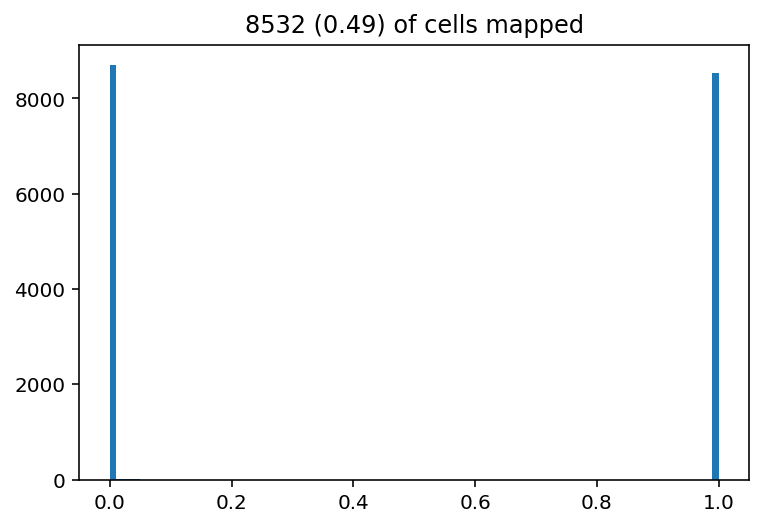

In [19]:
n_mapped_cells = np.sum(F_out > .5)
pct_mapped_cells =  n_mapped_cells / len(F_out)
plt.title('{:d} ({:.2f}) of cells mapped'.format(n_mapped_cells, pct_mapped_cells))
plt.hist(F_out, bins=100);

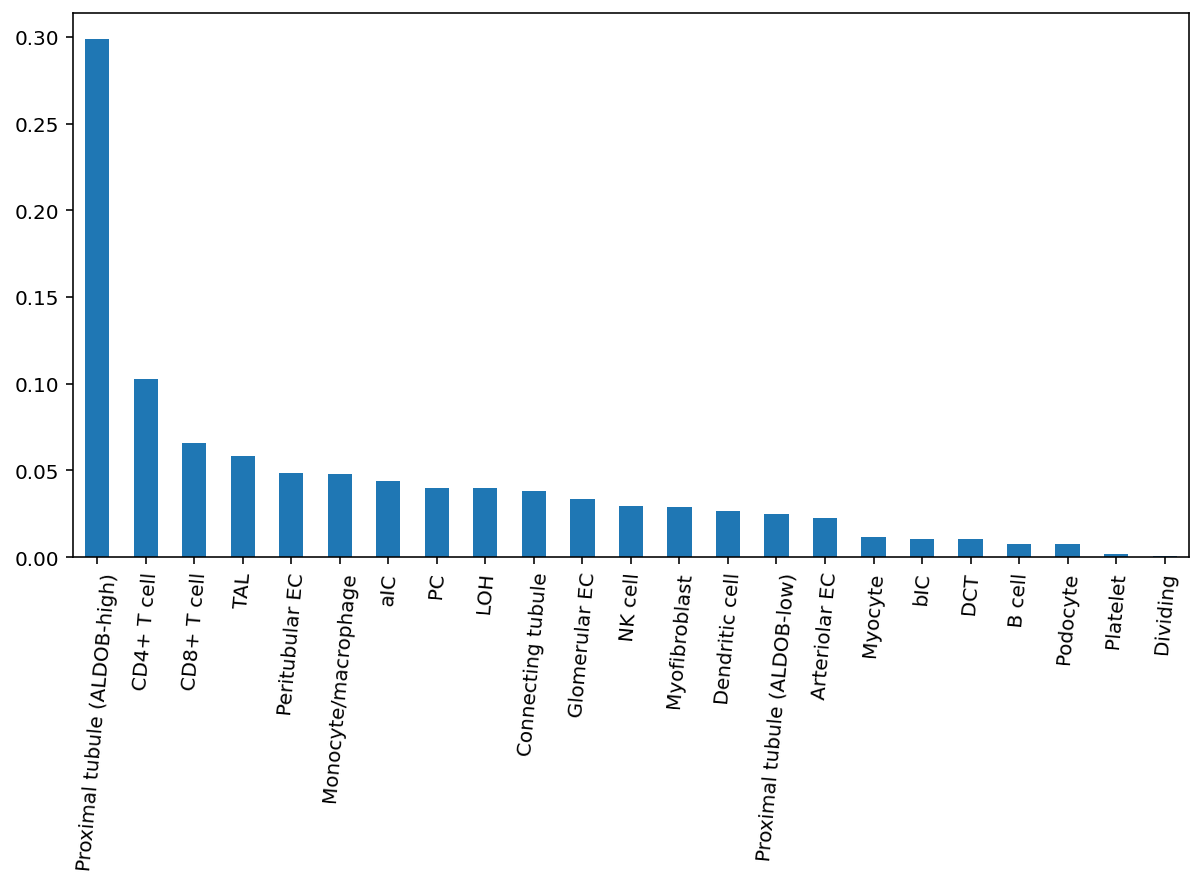

In [20]:
fracs = ad_sc.obs['subsampling.label'].value_counts() / ad_sc.n_obs
fracs.plot(kind='bar', rot=85, figsize=(10, 5));

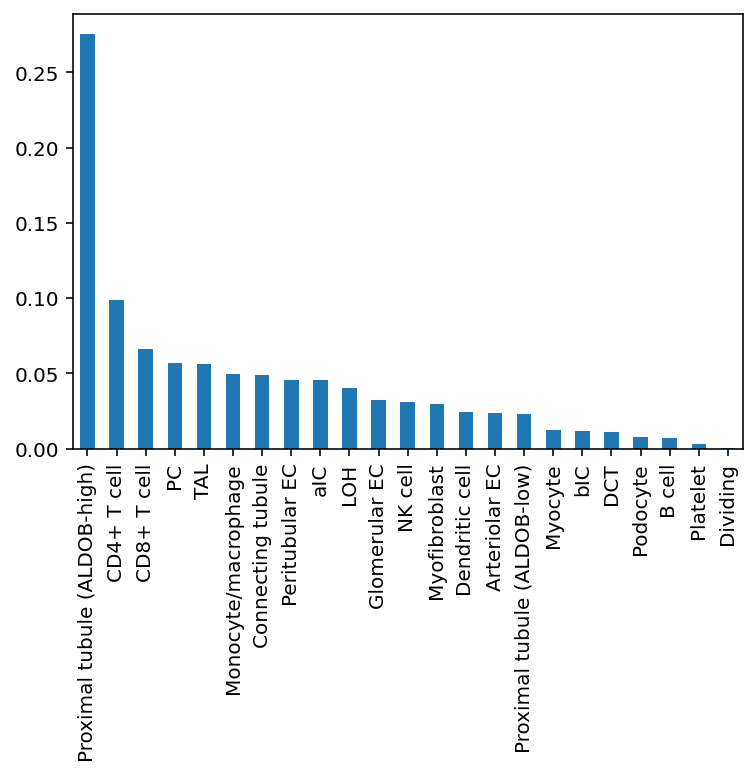

In [21]:
mask = F_out > 0.5
fracs_2 = ad_sc[mask, :].obs['subsampling.label'].value_counts() / ad_sc[mask, :].n_obs
fracs_2.plot(kind='bar');

***

#### TODO
- Transfer annotation can be part of mapping object, given that

In [22]:
'Annotation transfer from snRNAseq to spatial data'
# Use `mapping.utils.transfer_annotations_prob_filter`to transfer annotations onto space.
# Here, we transfer subclasses (ie cell types).
df_classes = mapping.utils.one_hot_encoding(ad_sc_fl.obs['subsampling.label'])
prob_assign = mapping.utils.transfer_annotations_prob_filter(output, F_out, df_classes)
prob_assign.head()

,Myofibroblast,Podocyte,LOH,Monocyte/macrophage,Dendritic cell,TAL,NK cell,Arteriolar EC,Peritubular EC,Glomerular EC,...,Myocyte,aIC,CD8+ T cell,Proximal tubule (ALDOB-high),DCT,B cell,bIC,CD4+ T cell,PC,Dividing
0,0.000069,3.109992e-08,0.000318,0.000002,4.040897e-08,1.524163e-07,0.000163,0.000081,9.026795e-08,0.000554,...,3.535422e-08,0.000947,0.000104,0.000205,1.812412e-04,0.000180,5.555953e-08,0.000067,0.000301,7.212228e-06
1,0.256821,5.947448e-02,0.097341,0.132603,7.575688e-02,3.711423e-01,0.083765,0.077208,2.829896e-01,0.143447,...,2.645125e-02,0.186811,0.682587,0.803456,1.362540e-07,0.009471,1.644155e-02,0.180152,0.999354,2.046297e-07
2,0.255008,1.082848e-01,0.436916,0.519960,3.049566e-01,6.637323e-01,0.416474,0.280016,4.114482e-01,0.282116,...,9.831274e-02,0.369869,0.621833,3.066727,4.985132e-02,0.056040,1.760504e-01,0.843900,0.201955,1.265210e-02
3,0.075172,4.127331e-02,0.043993,0.064876,4.865665e-03,6.159295e-07,0.081745,0.079915,5.111582e-02,0.025539,...,2.917576e-07,0.169966,0.059408,0.171311,4.098472e-07,0.009344,1.669307e-02,0.021549,0.744753,1.123137e-02
4,0.319091,1.599034e-01,1.306091,0.473602,2.458949e-01,1.251222e+00,0.523420,0.187676,5.181132e-01,0.328132,...,1.975803e-01,1.476958,1.049518,3.718220,1.286470e-01,0.130818,1.210223e-01,1.878704,0.247114,1.491812e-06


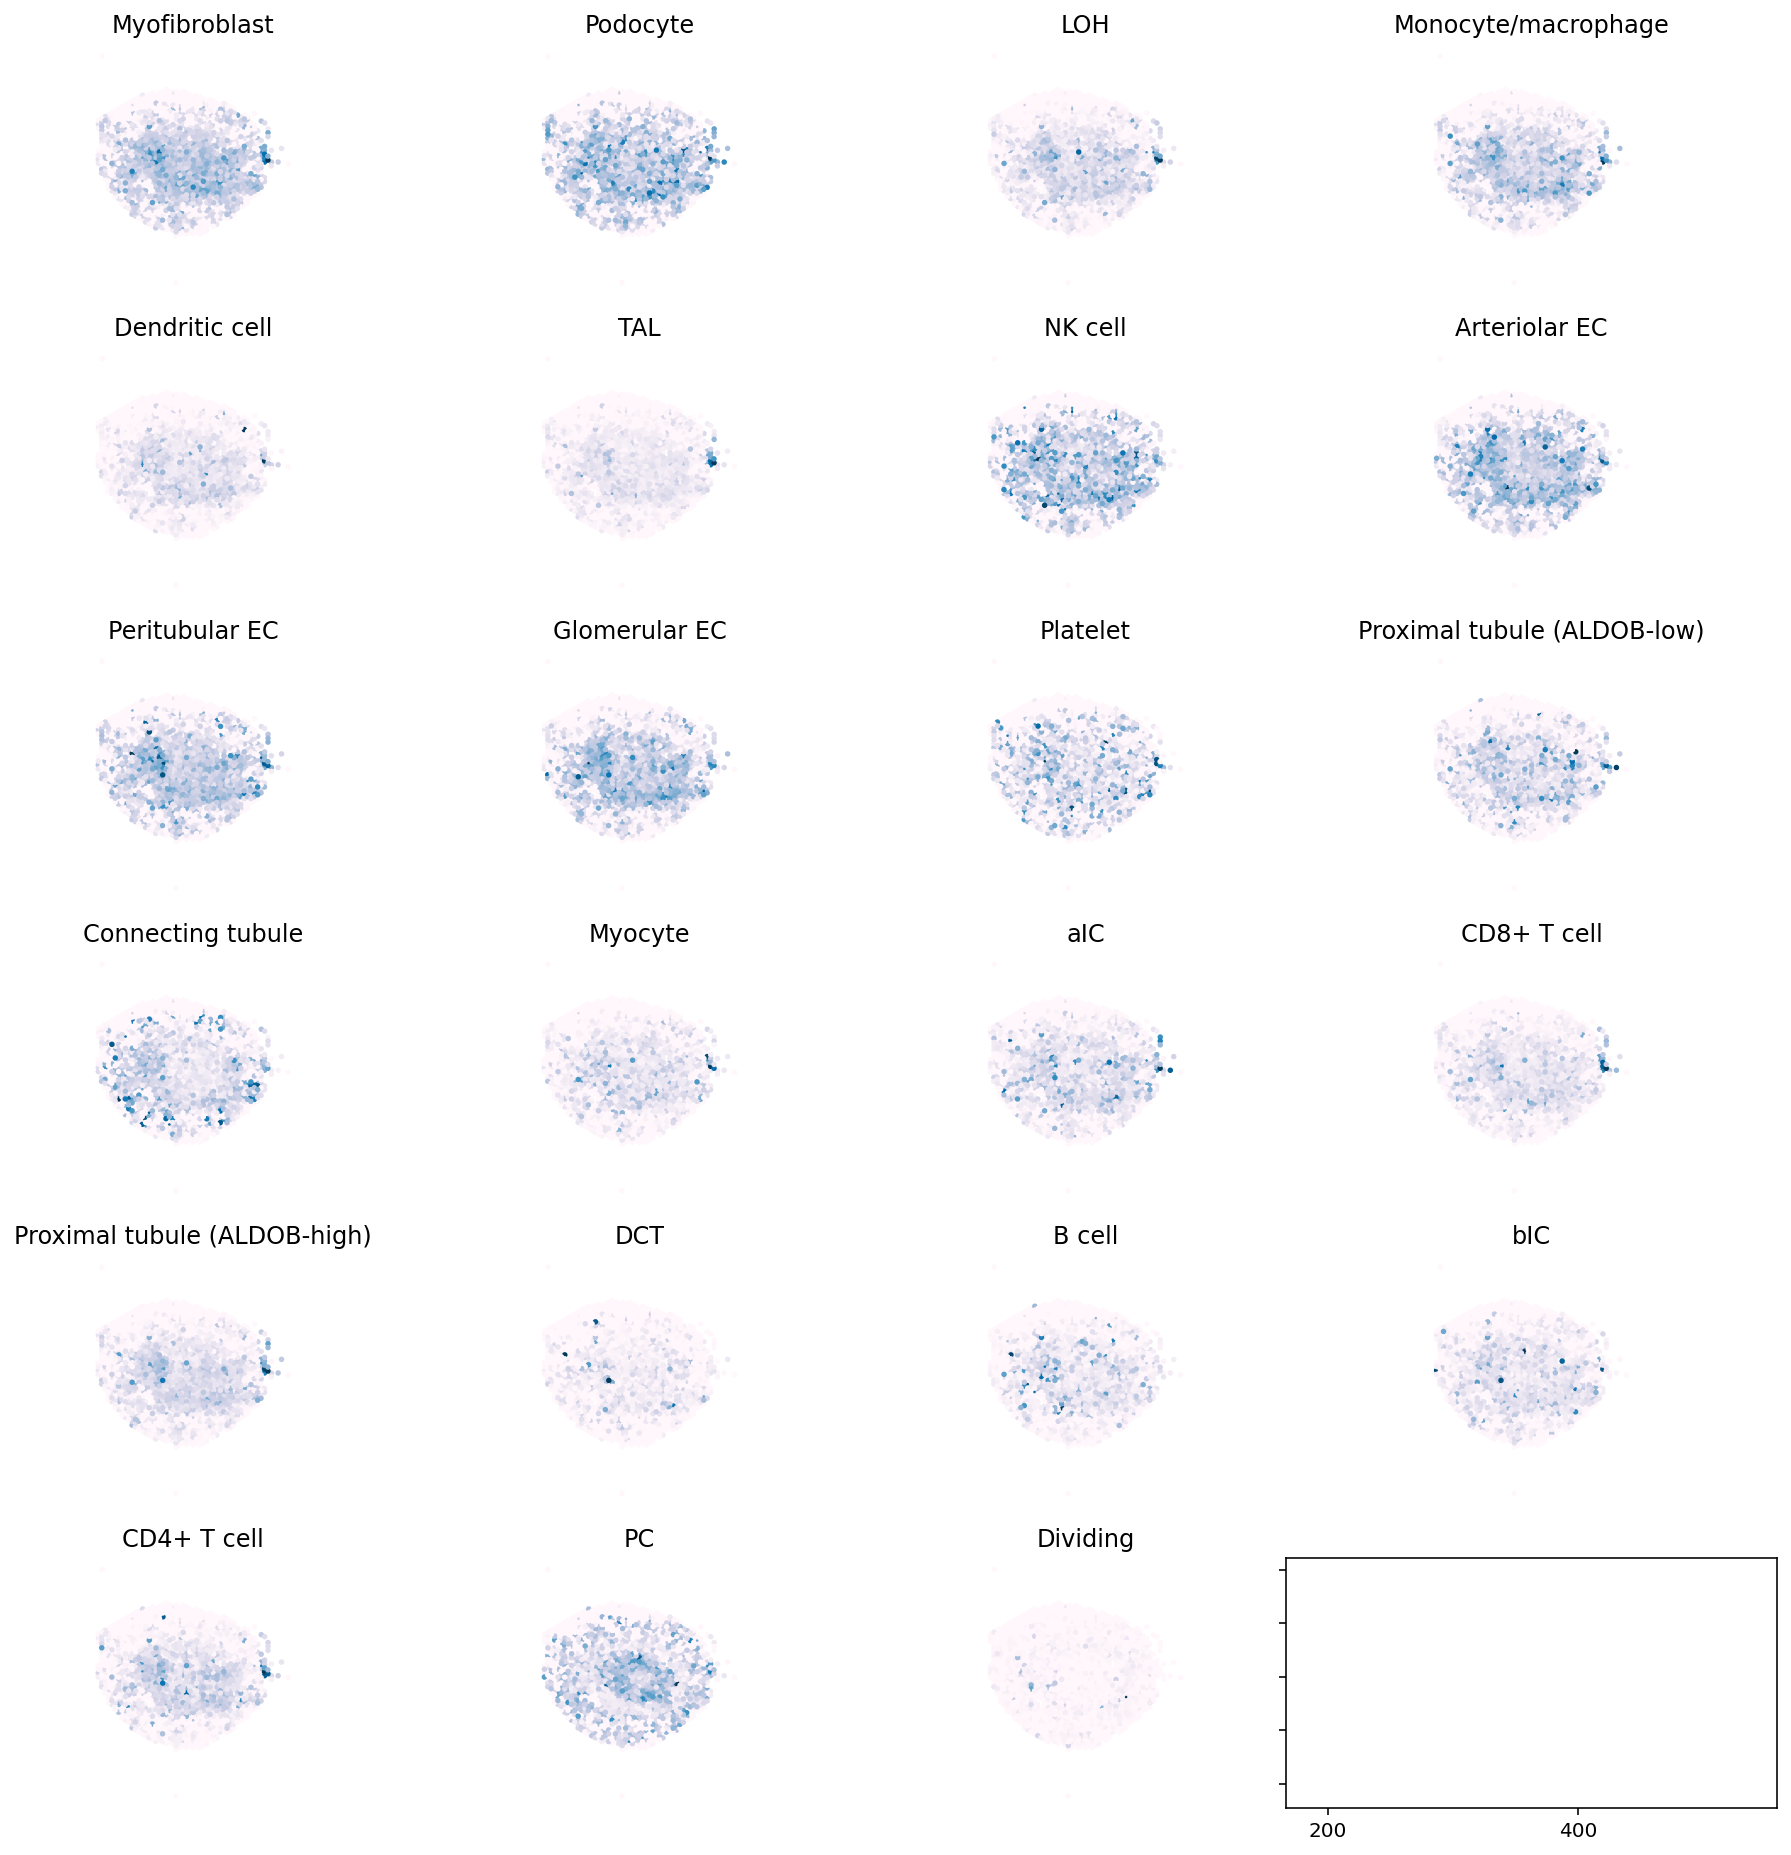

In [34]:
# compute cell type list
cell_types = list(ad_sc.obs['subsampling.label'].unique())

fig, axs = plt.subplots(nrows=6, ncols=4, figsize=(13, 13), sharex=True, sharey=True)
for ax, ct in zip(axs.flatten(), cell_types):
    ax.scatter(x=ad_sp.obs.x_lo, # gene profile of ad_sp doesn't matter
               y=ad_sp.obs.y_lo, 
               c=prob_assign[ct], 
               s=3, 
               cmap='PuBu');
    ax.set_title(ct)
    ax.set_aspect(1)
    ax.axis('off');
plt.tight_layout()